In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [3]:
df_sample = df.sample(n=1_500_000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


In [4]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

In [5]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
optuna_boost_params = {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.15604312608566637, 'subsample': 0.8182611788035248, 'min_samples_split': 14, 'min_samples_leaf': 5}
optuna_boost_params_prefixed = {f'classifier__{k}': v for k, v in optuna_boost_params.items()}
print(optuna_boost_params_prefixed)
sample_weights = compute_sample_weight('balanced', y_train)

{'classifier__n_estimators': 245, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.15604312608566637, 'classifier__subsample': 0.8182611788035248, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 5}


In [7]:
pipeline = clone(full_pipeline)
pipeline.set_params(**optuna_boost_params_prefixed)
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

C:\Program Files\Python\Anaconda\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('high_cat',
                                                  ThresholdFrequencyEncoder(),
                                                  ['Region_Code',
                                                   'Policy_Sales_Channel']),
                                                 ('bool',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output=False),
                                                  ['Gender', 'Vehicle_Damage']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'Year',
                                                                              '1-2 '
                                                                              'Year',
                                                                              '> '
                                                                              '2 '
                                                                              'Years']],
                                                                 dtype=<class 'numpy.int32'>),
                                                  ['Vehicle_Age'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.15604312608566637,
                                            max_depth=7, min_samples_leaf=5,
                                            min_samples_split=14,
                                            n_estimators=245, random_state=42,
                                            subsample=0.8182611788035248))])

In [8]:
model = pipeline

# Делаем предсказания на тестовой выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

# Вычисляем метрики
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC-AUC (только если есть вероятности)
roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None


Лучший метод: Optuna
  F1-Score: 0.448
  Precision: 0.2966
  Recall: 0.915
  ROC-AUC: 0.8707


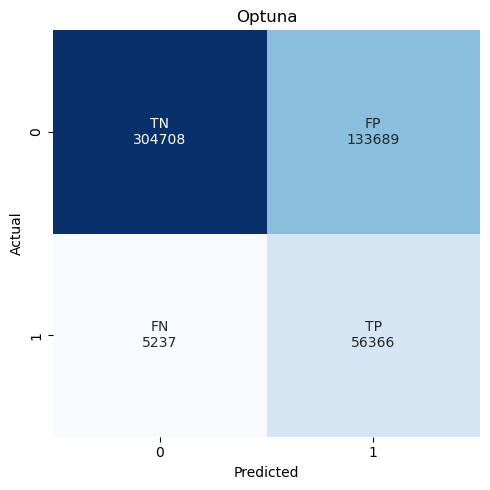

In [9]:
print(f"\nЛучший метод: Optuna")
print(f"  F1-Score: {round(f1, 4)}")
print(f"  Precision: {round(precision, 4)}")
print(f"  Recall: {round(recall, 4)}")
print(f"  ROC-AUC: {round(roc_auc, 4) if roc_auc else 'N/A'}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cm = confusion_matrix(y_test, y_pred)

# Аннотации TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()
annot = np.array([[f'TN\n{tn}', f'FP\n{fp}'],
                  [f'FN\n{fn}', f'TP\n{tp}']])

# Heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=ax, cbar=False)
ax.set_title('Optuna')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()